# Property insurance risk assessment: 
using public data to estimate building features that affect insurance value


In [112]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import shutil
# for dirname, _, filenames in os.walk('D:/1999Faye/自我拓展！/Python/SVM支持向量机'):
#     for filename in filenames:
#         os.path.join(dirname, filename)
import cv2
from tqdm import tqdm
import hashlib

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


## Part 1: Self-constructed CNN model

### Define the constant

In [113]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Remove the duplicate images

In [3]:
# hashes = set()
# directory = "../uni_project_data/uni_project_data/street_view_juny12"

# for filename in os.listdir("../uni_project_data/uni_project_data/street_view_juny12"):
#     path = os.path.join(directory, filename)
#     digest = hashlib.sha1(open(path,'rb').read()).digest()
#     if digest not in hashes:
#         hashes.add(digest)
#     else:
#         os.remove(path)

#### randomly pick the training/validation/test set

In [22]:
# load the property information
pro = pd.read_csv("../uni_project_data/uni_project_data/properties_juny12.csv")
pro['property_id'] = 'gsv_' + pro['property_id'] + '.jpg'


In [10]:
# # select 2000 samples as training set and 50 as test set
# def moveFile_train(op, np):
#     filenames = os.listdir("../uni_project_data/uni_project_data/street_view_juny12")
#     trainingset = random.sample(filenames, 2050) 
#     for i in trainingset:
#         # copy the training file to another path
#         shutil.copyfile(os.path.join(op,i), os.path.join(np,i))
#     return

# path = '../uni_project_data/uni_project_data/samplenew'
# if not os.path.exists(path):
#     os.mkdir(path)

# if __name__ == '__main__':
#     src = r'../uni_project_data/uni_project_data/street_view_juny12'
#     dst = r'../uni_project_data/uni_project_data/samplenew'
#     moveFile_train(src,dst)


In [119]:
# # select 5000 samples as training set 
# def moveFile_train(op, np):
#     filenames = os.listdir("../uni_project_data/uni_project_data/street_view_juny12")
#     trainingset = random.sample(filenames, 5000) 
#     for i in trainingset:
#         # copy the training file to another path
#         shutil.copyfile(os.path.join(op,i), os.path.join(np,i))
#     return

# path = '../uni_project_data/uni_project_data/sample5000'
# if not os.path.exists(path):
#     os.mkdir(path)

# if __name__ == '__main__':
#     src = r'../uni_project_data/uni_project_data/street_view_juny12'
#     dst = r'../uni_project_data/uni_project_data/sample5000'
#     moveFile_train(src,dst)

In [120]:
filenames = os.listdir("../uni_project_data/uni_project_data/sample5000")
sample_df = pd.DataFrame({
    'property_id': filenames
})
sampledf = pro.merge(sample_df, on = 'property_id')


In [19]:
# detached = sampledf.loc[sampledf.propertyType == 'Detached', 'property_id']
# detached.tolist()

# path = '../uni_project_data/uni_project_data/detached'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in detached:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/detached',i))
        

# semi_detached = sampledf.loc[sampledf.propertyType == 'Semi-Detached', 'property_id']
# semi_detached.tolist()

# path = '../uni_project_data/uni_project_data/semi_detached'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in semi_detached:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/semi_detached',i))

# unknown = sampledf.loc[sampledf.propertyType == 'Unknown', 'property_id']
# unknown.tolist()

# path = '../uni_project_data/uni_project_data/unknown'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in unknown:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/unknown',i))


# Terraced = sampledf.loc[sampledf.propertyType == 'Terraced', 'property_id']
# Terraced.tolist()

# path = '../uni_project_data/uni_project_data/Terraced'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in Terraced:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/Terraced',i))


# Flat = sampledf.loc[sampledf.propertyType == 'Flat', 'property_id']
# Flat.tolist()

# path = '../uni_project_data/uni_project_data/Flat'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in Flat:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/Flat',i))


<AxesSubplot:>

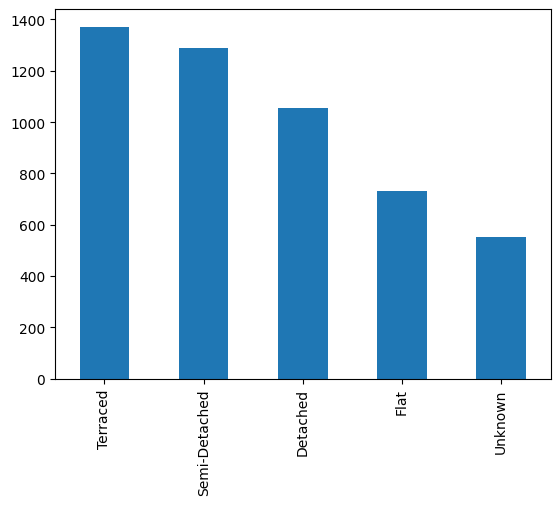

In [121]:
sampledf['propertyType'].value_counts().plot.bar()

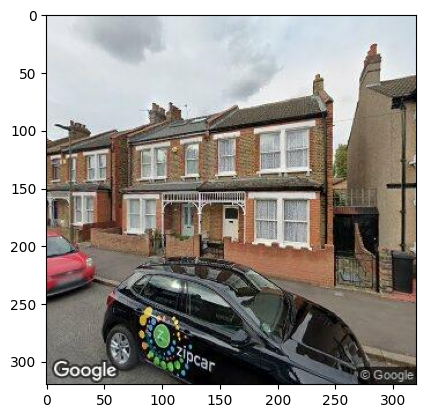

In [4]:
# sample = random.choice(filenames)
# image = load_img("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/"+sample)
# plt.imshow(image)

### Spliting the train and test set

In [134]:
train, validation = train_test_split(sampledf, test_size=0.1, random_state=66)
train, test = train_test_split(train, test_size=1/9, random_state=66)
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

<AxesSubplot:>

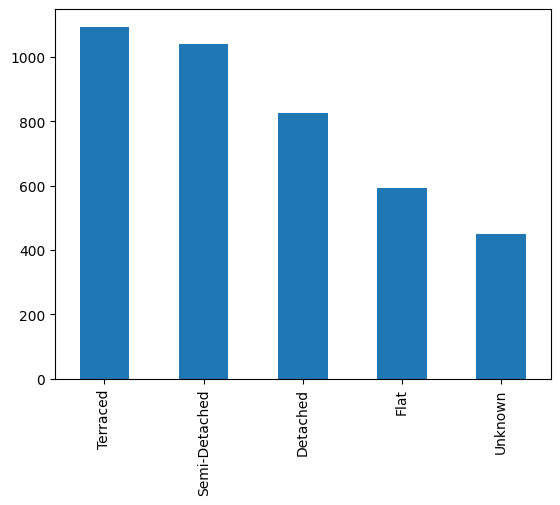

In [135]:
train['propertyType'].value_counts().plot.bar()

<AxesSubplot:>

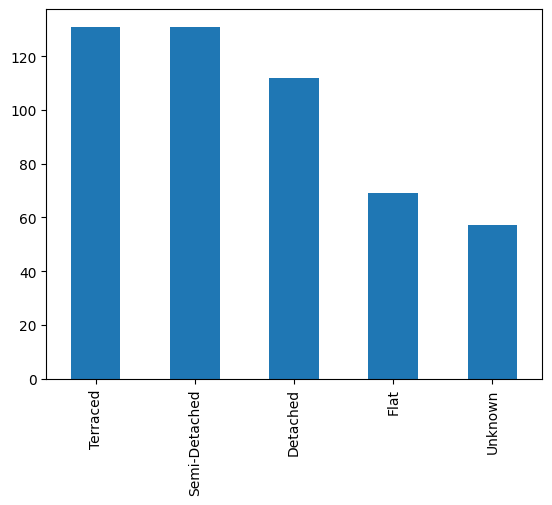

In [136]:
test['propertyType'].value_counts().plot.bar()

<AxesSubplot:>

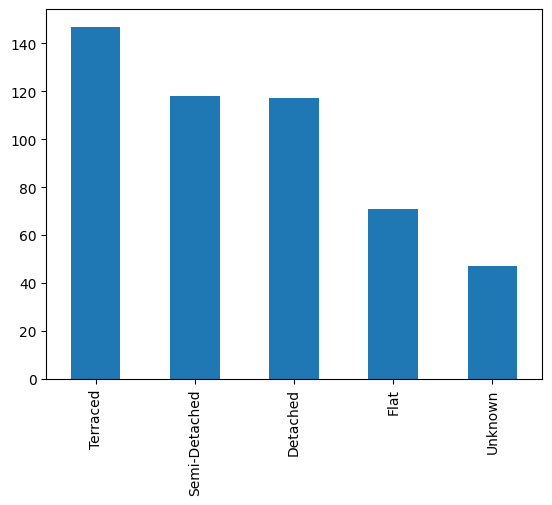

In [137]:
validation['propertyType'].value_counts().plot.bar()

In [139]:
train_num = train.shape[0]
validation_num = validation.shape[0]
# In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. You may see these values used in models in the literature and in tutorials.
# batch_size=64
batch_size=32
# The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. You may see examples of the number of epochs in the literature and in tutorials set to 10, 100, 500, 1000, and larger.
# epochs=100
epochs=50

### Building CNN model

In [155]:
model = Sequential()

# Convolution layer
model.add(Conv2D(32, (4, 4), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 317, 317, 32)      1568      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 158, 158, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 156, 156, 64)      18496     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 78, 78, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 76, 76, 128)       73856     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 38, 38, 128)     

### Prevent over-fitting: callback

In [142]:
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)

In [143]:
# We will reduce the learning rate when then accuracy not increase for 3 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0001)

In [144]:
callbacks = [earlystop, learning_rate_reduction]
# callbacks = [earlystop]

### Image generator

In [145]:
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    # horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator = train_idg.flow_from_dataframe(
    train, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4000 validated image filenames belonging to 5 classes.


In [146]:
validation_idg = ImageDataGenerator(rescale=1./255)
validation_imagegenerator = validation_idg.flow_from_dataframe(
    validation, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 5 classes.


In [16]:
# # example: 

# example_df = train.sample(n=1).reset_index(drop=True)
# example_generator = train_idg.flow_from_dataframe(
#     example_df, 
#     "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

In [17]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

### Fit on the Training set and make predcitons on the Validation set

In [157]:

history = model.fit_generator(
    train_imagegenerator, 
    epochs=epochs,
    validation_data=validation_imagegenerator,
    validation_steps=validation_num//batch_size,
    steps_per_epoch=80,
    callbacks=callbacks
)




Epoch 1/50
80/80 [==============================] - 184s 2s/step - loss: 1.5769 - accuracy: 0.2594 - val_loss: 1.5576 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/50
80/80 [==============================] - 182s 2s/step - loss: 1.5657 - accuracy: 0.2754 - val_loss: 1.5489 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 3/50
80/80 [==============================] - 184s 2s/step - loss: 1.5581 - accuracy: 0.2734 - val_loss: 1.5524 - val_accuracy: 0.2417 - lr: 0.0010
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 1.5347 - accuracy: 0.3102
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
80/80 [==============================] - 182s 2s/step - loss: 1.5347 - accuracy: 0.3102 - val_loss: 1.5683 - val_accuracy: 0.2354 - lr: 0.0010
Epoch 5/50
80/80 [==============================] - 179s 2s/step - loss: 1.5331 - accuracy: 0.3051 - val_loss: 1.5185 - val_accuracy: 0.3167 - lr: 1.0000e-04
Epoch 6/50
80/80 [==============================] - 182s 2s/step -

### Visualize the result

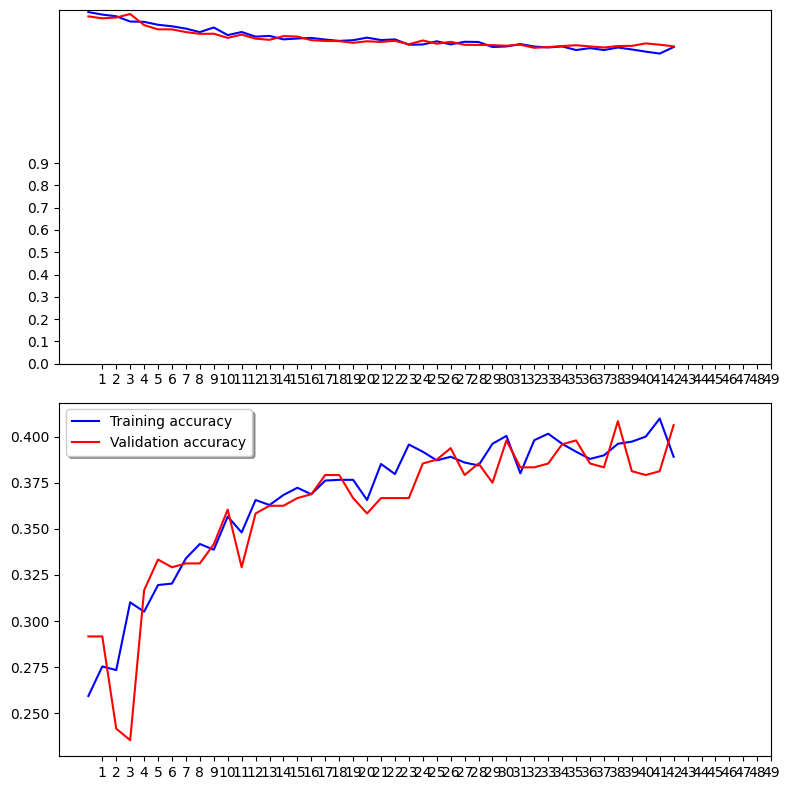

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Part2: 分类是否有房子

手动分类2000多张图片，然后利用SVM将剩下的所有图片分类为【house/not_houst】


#### Building SVM model

SVM algorithm is to be used when their is shortage of data in our dataset

In [20]:
DATADIR = '../street_view/street_svm'
Label = ['house','not_house']

IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

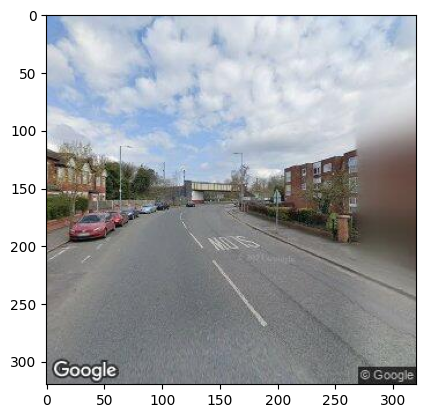

In [21]:
# show a pic
for category in Label:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=load_img(os.path.join(path,img))
        
        
        plt.imshow(img_array)
        # plt.imshow(img_array)
        plt.show()
        
        break
    break

In [22]:
import glob
all_data=[]
for category in Label:
    path=os.path.join(DATADIR, category)
    # img_path = glob.glob(path+'/*.jpg')
    class_num=Label.index(category)
    # for img in img_path:
    for img in os.listdir(path):
        # img_array=cv2.imread(img)
        img_array=cv2.imread(os.path.join(path,img))
        
        all_data.append([img_array,class_num])

img_num = len(all_data)

In [23]:
# X should be of type (training_data_length , -1) because SVM takes 2D input to train 

X=[]
y=[]

for categories, label in all_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(img_num,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

X.shape

(90, 307200)

In [24]:
# flattening the array
X = X/255.0

In [25]:
y=np.array(y)
y.shape

(90,)

split the train and validation data

In [26]:
# applying train_test_split on our data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

fit the model

In [27]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [28]:
# use gridsearchcv to automatically choose the parameters for SVM
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear', 'rbf','poly']}
svc=svm.SVC(probability=True)
svm_model=GridSearchCV(svc,param_grid)

svm_model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']})

evaluate the model use validation set

In [29]:
pre_test_y = svm_model.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy on validation set is",accuracy_score(y_test,pre_test_y))

Accuracy on validation set is 0.6956521739130435


The accuracy of predicting the house/not_house is around 80% by using SVM. Then try to use CNN to do the image classification. 

#### Building CNN model

In [30]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [31]:
files = os.listdir("../street_view/street_cnn/train_label/")
label = []
for img in files:
    category = img.split('.')[0]
    if category == 'house':
        label.append('house')
    else:
        label.append('not_house')

df = pd.DataFrame({
    'filename': files,
    'category': label
})

df

,filename,category
0,house.1.jpg,house
1,house.10.jpg,house
2,house.100.jpg,house
3,house.1000.jpg,house
4,house.1001.jpg,house
...,...,...
2545,not_house.95.jpg,not_house
2546,not_house.96.jpg,not_house
2547,not_house.97.jpg,not_house
2548,not_house.98.jpg,not_house


In [32]:
# Use the VGG16 model to do the image classification. 

VGGmodel = Sequential()
VGGmodel.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Flatten())
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=2, activation="softmax"))

VGGmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
VGGmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [33]:
# Control the training

# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
# early = EarlyStopping(monitor='val_acc', verbose=1, mode='auto')

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [34]:
train_house, validate_house = train_test_split(df, test_size=0.20, random_state=22)
train_house = train_house.reset_index(drop=True)
validate_house = validate_house.reset_index(drop=True)

num_train = train_house.shape[0]
num_validate = validate_house.shape[0]
batch_size=32

In [35]:
# Generate the training image
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_housegenerator = train_idg.flow_from_dataframe(
    train_house, 
    "../street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2040 validated image filenames belonging to 2 classes.


In [36]:
test_idg = ImageDataGenerator(rescale=1./255)

test_housegenerator = test_idg.flow_from_dataframe(
    validate_house, 
    "../street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 510 validated image filenames belonging to 2 classes.


In [37]:
# Fit the model
epochs=50
history_house = VGGmodel.fit_generator(
    steps_per_epoch=10, 
    generator = train_housegenerator, 
    epochs=50,
    validation_data=test_housegenerator,
    validation_steps=10, 
    callbacks=[checkpoint,early]
)


Epoch 1/50
10/10 [==============================] - 129s 13s/step - loss: 2.7764 - accuracy: 0.6938 - val_loss: 0.6111 - val_accuracy: 0.8656
Epoch 2/50
10/10 [==============================] - 123s 12s/step - loss: 0.5344 - accuracy: 0.8846 - val_loss: 0.4150 - val_accuracy: 0.8625
Epoch 3/50
10/10 [==============================] - 125s 13s/step - loss: 0.3948 - accuracy: 0.8687 - val_loss: 0.3893 - val_accuracy: 0.8687
Epoch 4/50
10/10 [==============================] - 119s 12s/step - loss: 0.3848 - accuracy: 0.8719 - val_loss: 0.3785 - val_accuracy: 0.8750
Epoch 5/50
10/10 [==============================] - 119s 12s/step - loss: 0.4363 - accuracy: 0.8594 - val_loss: 0.3819 - val_accuracy: 0.8781
Epoch 6/50
10/10 [==============================] - 117s 12s/step - loss: 0.3493 - accuracy: 0.8942 - val_loss: 0.3912 - val_accuracy: 0.8750
Epoch 7/50
10/10 [==============================] - 119s 12s/step - loss: 0.4281 - accuracy: 0.8531 - val_loss: 0.3950 - val_accuracy: 0.8875
Epoch 

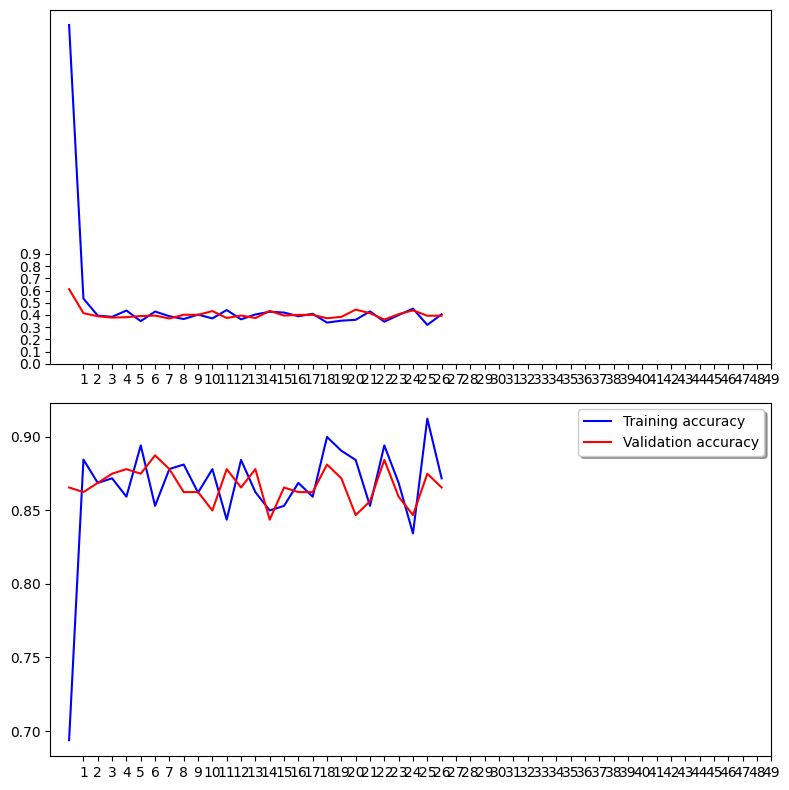

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history_house.history['loss'], color='b', label="Training loss")
ax1.plot(history_house.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_house.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_house.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

We enconter a problem of over-fitting

In [39]:
housemodel = Sequential()

# Convolution layer
housemodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(320, 320, 3)))
# housemodel.add(BatchNormalization())
# housemodel.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
housemodel.add(MaxPooling2D())
housemodel.add(Dropout(0.25))

housemodel.add(Conv2D(64, (3, 3), activation='relu'))
# housemodel.add(BatchNormalization())
# housemodel.add(MaxPooling2D(pool_size=(2, 2)))
housemodel.add(MaxPooling2D())
housemodel.add(Dropout(0.25))

housemodel.add(Conv2D(128, (3, 3), activation='relu'))
# housemodel.add(BatchNormalization())
# housemodel.add(MaxPooling2D(pool_size=(2, 2)))
housemodel.add(MaxPooling2D())
housemodel.add(Dropout(0.25))


housemodel.add(Flatten())
housemodel.add(Dense(512, activation='relu'))
# housemodel.add(BatchNormalization())
# housemodel.add(Dropout(0.5))
housemodel.add(Dense(256, activation='relu'))
housemodel.add(Dense(64, activation='relu'))
housemodel.add(Dense(2, activation='softmax')) 

housemodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

housemodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 159, 159, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 78, 78, 64)       

In [40]:
# Try original self-constructed model
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Generate the training image
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_housegenerator = train_idg.flow_from_dataframe(
    train_house, 
    "../street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_idg = ImageDataGenerator(rescale=1./255)

test_housegenerator = test_idg.flow_from_dataframe(
    validate_house, 
    "../street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# Fit the model
epochs=50
history_house2 = housemodel.fit_generator(
    steps_per_epoch=10, 
    generator = train_housegenerator, 
    epochs=epochs,
    validation_data=test_housegenerator,
    validation_steps=10, 
    callbacks=[checkpoint,early]
)


Found 2040 validated image filenames belonging to 2 classes.
Found 510 validated image filenames belonging to 2 classes.
Epoch 1/50
10/10 [==============================] - 31s 3s/step - loss: 3.0775 - accuracy: 0.7969 - val_loss: 0.5255 - val_accuracy: 0.8625
Epoch 2/50
10/10 [==============================] - 30s 3s/step - loss: 0.3909 - accuracy: 0.8625 - val_loss: 0.4902 - val_accuracy: 0.8500
Epoch 3/50
10/10 [==============================] - 31s 3s/step - loss: 0.3752 - accuracy: 0.8594 - val_loss: 0.4166 - val_accuracy: 0.8813
Epoch 4/50
10/10 [==============================] - 30s 3s/step - loss: 0.3950 - accuracy: 0.8500 - val_loss: 0.4806 - val_accuracy: 0.8625
Epoch 5/50
10/10 [==============================] - 29s 3s/step - loss: 0.3562 - accuracy: 0.8656 - val_loss: 0.3841 - val_accuracy: 0.8625
Epoch 6/50
10/10 [==============================] - 30s 3s/step - loss: 0.3390 - accuracy: 0.8846 - val_loss: 0.3975 - val_accuracy: 0.8750
Epoch 7/50
10/10 [=====================

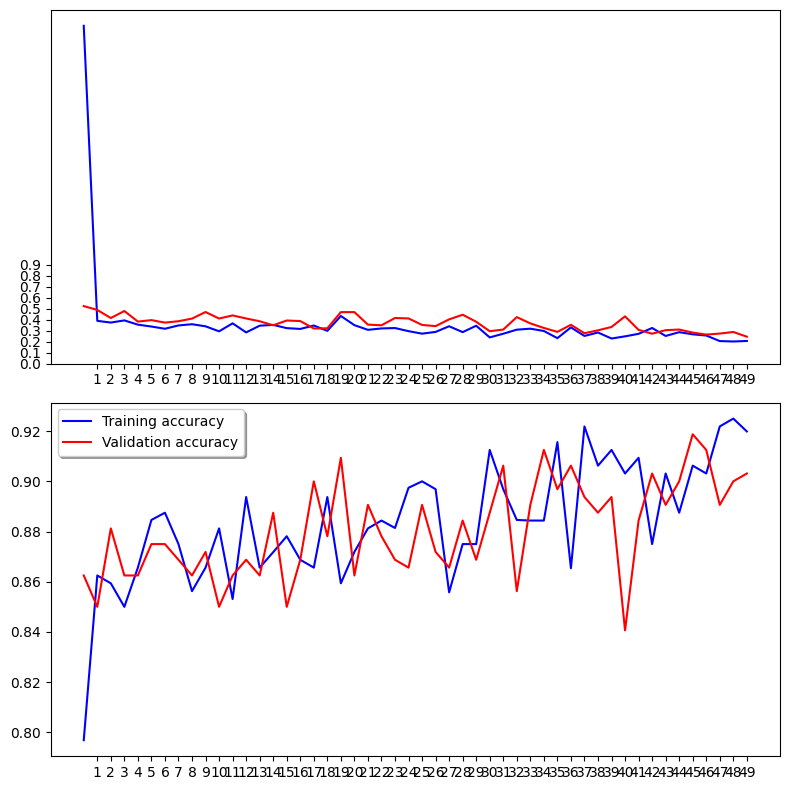

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history_house2.history['loss'], color='b', label="Training loss")
ax1.plot(history_house2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_house2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_house2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#### Use the selected model to make predictions of house/not-house

Prepare Testing Data

In [45]:
non_labeled = os.listdir("../street_view/street_view/")
test_df = pd.DataFrame({
    'property_id': non_labeled
})
num_test = test_df.shape[0]

In [46]:
num_test

16965

In [47]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=64

test_gen = ImageDataGenerator(rescale=1./255)
test_housegenerator = test_gen.flow_from_dataframe(
    test_df, 
    "../street_view/street_view/", 
    x_col='property_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)




Found 16965 validated image filenames.


In [51]:
predict = housemodel.predict_generator(test_housegenerator, steps=np.ceil(num_test/batch_size))

In [52]:
# For categoral classication task, the prediction will give out the probability of each category. We need to pick the category that have the highest probability

test_df['category'] = np.argmax(predict, axis=-1)

# convert the predict category back into generator classes
label_map = dict((v,k) for k,v in train_housegenerator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)



In [53]:
test_df

,property_id,category
0,gsv_000024bc-511f-4641-ad3c-56e7dd445526.jpg,house
1,gsv_00035c6a-4ccf-4215-9680-b215fe29cc59.jpg,house
2,gsv_0008ffbb-3089-4b03-806a-2d62da8dc810.jpg,house
3,gsv_00114f24-9677-4337-bf86-a5c4554c7567.jpg,house
4,gsv_001758e2-66d7-49e0-b37c-8db75a504ec9.jpg,house
...,...,...
16960,gsv_ffe34431-cb7c-4011-94a2-f658572fd7d6.jpg,house
16961,gsv_ffee2332-6c00-4a62-a29e-52665c1e54f0.jpg,house
16962,gsv_fff4b546-1af7-4d8c-824f-4eb640c33a26.jpg,house
16963,gsv_fff9212b-cb40-429a-8f81-fe273159a867.jpg,house


<AxesSubplot:>

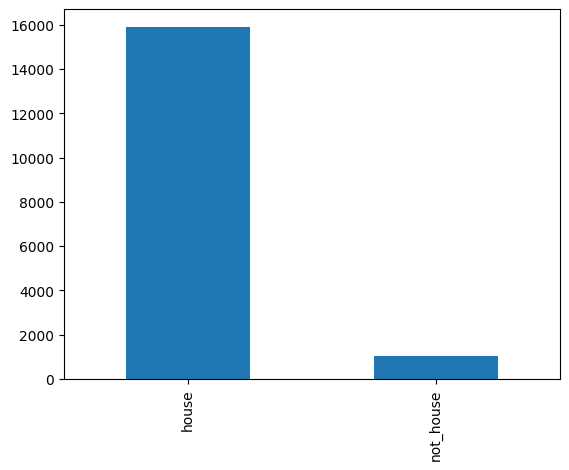

In [54]:
# test_df['category'].value_counts().plot.bar()

In [55]:
# convert the test_df to csv
# test_df.to_csv("")

# combine the house/not_house with the properties.csv
housedf = pd.read_csv("../street_view/house_label.csv")
housedf

,Unnamed: 0,property_id,category
0,0,gsv_000024bc-511f-4641-ad3c-56e7dd445526.jpg,house
1,1,gsv_00035c6a-4ccf-4215-9680-b215fe29cc59.jpg,house
2,2,gsv_0008ffbb-3089-4b03-806a-2d62da8dc810.jpg,house
3,3,gsv_00114f24-9677-4337-bf86-a5c4554c7567.jpg,house
4,4,gsv_001758e2-66d7-49e0-b37c-8db75a504ec9.jpg,house
...,...,...,...
16960,16960,gsv_ffe34431-cb7c-4011-94a2-f658572fd7d6.jpg,house
16961,16961,gsv_ffee2332-6c00-4a62-a29e-52665c1e54f0.jpg,house
16962,16962,gsv_fff4b546-1af7-4d8c-824f-4eb640c33a26.jpg,house
16963,16963,gsv_fff9212b-cb40-429a-8f81-fe273159a867.jpg,house


<AxesSubplot:>

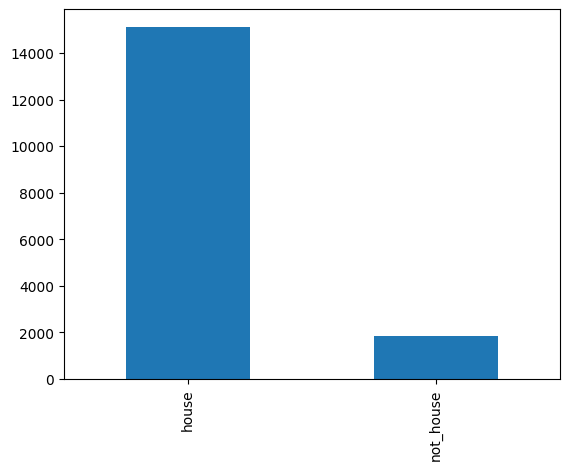

In [57]:
housedf['category'].value_counts().plot.bar()

In [56]:
pro_label = pro.merge(housedf, on = 'property_id')
pro_label.head()

,Unnamed: 0_x,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id,Unnamed: 0_y,category
0,0,"12, Gorsey Brigg, Dronfield Woodhouse, Dronfie...",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,53.29986,-1.49446,gsv_60d9dd15-c5a0-4d9c-a341-a1d47add49d5.jpg,6457,house
1,0,"5, Highgate Lane, Dronfield, Derbyshire S18 1UB",Detached,4.0,https://www.rightmove.co.uk/house-prices/detai...,53.29135,-1.45975,gsv_4a586e80-181a-4b82-b5c3-2d789436bb14.jpg,4916,house
2,0,"125, Gosforth Lane, Dronfield, Derbyshire S18 1RB",Detached,3.0,https://www.rightmove.co.uk/house-prices/detai...,53.29763,-1.47573,gsv_93680b6c-237e-44d3-8f40-959a14b80cad.jpg,9778,house
3,0,"80, Shakespeare Crescent, Dronfield, Derbyshir...",Detached,3.0,https://www.rightmove.co.uk/house-prices/detai...,53.29259,-1.45644,gsv_5d49758b-f148-4d06-bbae-3eb23f5c68fb.jpg,6202,house
4,0,"21, Gainsborough Road, Dronfield, Derbyshire S...",Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,53.29740,-1.48503,gsv_4645f5eb-de7c-474f-8d7e-b59fa8c55f19.jpg,4635,house


In [ ]:
# IMAGE_WIDTH=320
# IMAGE_HEIGHT=320
# IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# IMAGE_CHANNELS=3

# pro_label_house = pro_label[pro_label.category == 'house']
# train2, test2 = train_test_split(pro_label_house, test_size=0.20, random_state=33)
# train2 = train2.reset_index(drop=True)
# test2 = test2.reset_index(drop=True)

# batch_size=64
# epochs=50

# model = Sequential()

# # Convolution layer
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # max pool layer
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))


# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax')) 

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

# earlystop = EarlyStopping(patience=10)

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.1, 
#                                             min_lr=0.0001)

# callbacks = [earlystop, learning_rate_reduction]

# train_idg = ImageDataGenerator(
#     rotation_range=10, # randomly rotate images
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.1,  # randomly zoom image 
#     horizontal_flip=True,  # randomly flip images
#     width_shift_range=0.1,  # randomly shift images horizontally
#     height_shift_range=0.1  # randomly shift images vertically
# )

# train_imagegenerator2 = train_idg.flow_from_dataframe(
#     train2, 
#     # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     "../street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

# test_idg = ImageDataGenerator(rescale=1./255)
# test_imagegenerator2 = test_idg.flow_from_dataframe(
#     test2, 
#     # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     "../street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

# history2 = model.fit_generator(
#     train_imagegenerator2, 
#     epochs=epochs,
#     validation_data=test_imagegenerator2,
#     # validation_steps=test_num//batch_size,
#     # steps_per_epoch=train_num//batch_size,
#     callbacks=callbacks
# )

In [ ]:
##### 最后如果跑全部数据，可以直接用pro_label就行了，就不需要这个框了

IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

samples1 = os.listdir("../street_view/street_example")
df2 = pd.DataFrame(samples1, columns=['property_id'])

df3 = pd.merge(df2, pro_label[['property_id', 'propertyType', 'category']], on='property_id')
# 只保留房子部分！！
df4 = df3[df3.category == 'house']

train, test = train_test_split(df4, test_size=0.20, random_state=33)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

batch_size=64
epochs=50

model = Sequential()

# Convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0001)

callbacks = [earlystop, learning_rate_reduction]

train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator = train_idg.flow_from_dataframe(
    train, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "../street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_idg = ImageDataGenerator(rescale=1./255)
test_imagegenerator = test_idg.flow_from_dataframe(
    test, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "../street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

history = model.fit_generator(
    train_imagegenerator, 
    epochs=epochs,
    validation_data=test_imagegenerator,
    # validation_steps=test_num//batch_size,
    # steps_per_epoch=train_num//batch_size,
    callbacks=callbacks
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 159, 159, 32)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 159, 159, 32)      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 78, 78, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 78, 78, 64)       

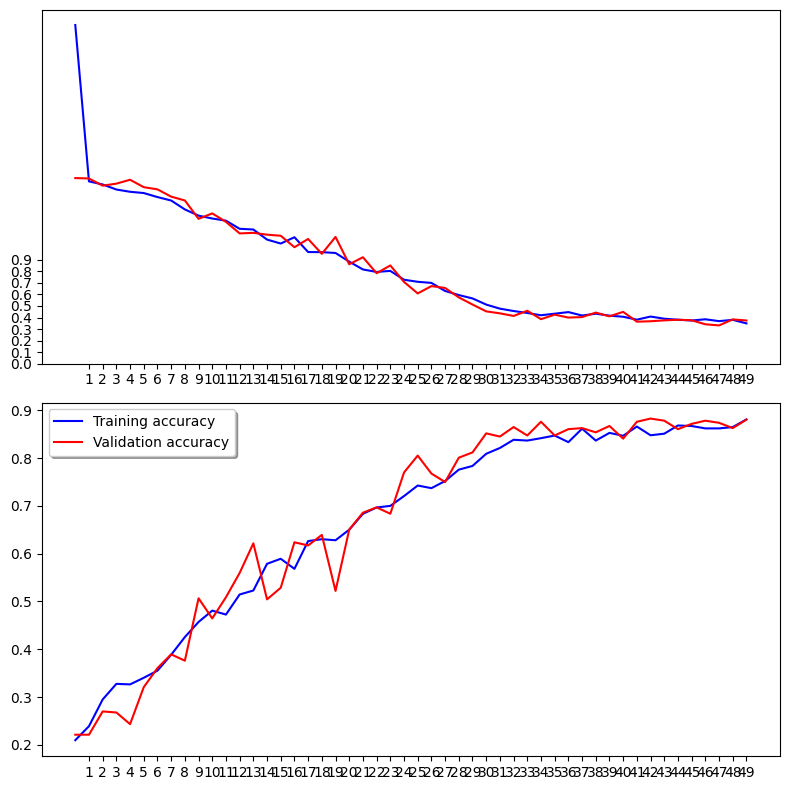

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Part 3: Image Pre-processing

#### try the methods of Edge detection and Image segmentation to enhance the characteristics of images. 

#### Edge detection

creat the edge image and save them in the 'sample_edge' folder

In [153]:
path = '../uni_project_data/uni_project_data/sample_edge5000'
if not os.path.exists(path):
    os.mkdir(path)


# example of edge detection
filenames = os.listdir("../uni_project_data/uni_project_data/sample5000")
for file in filenames:
    # read the image
    sample = cv2.imread('../uni_project_data/uni_project_data/sample5000/' + file)
    # turn RGB into grey image
    grey_sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

    # # show the grey image
    # cv2.imshow("Grey Image",grey_sample)
    # cv2.waitKey()
    
    # Gaussian denoising filter
    Gau_img = cv2.GaussianBlur(grey_sample, (7, 7), 1.5)
    # Gau_img = cv2.GaussianBlur(grey_sample, (5, 5), 2)
    # Gau_img = cv2.GaussianBlur(grey_sample, (5, 5), 1.5)


    # # 使用Canny算法进行边缘检测
    # edges = cv2.Canny(sample, threshold1, threshold2)

    # # 显示边缘图像
    # cv2.imshow('Edges', edges)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


    #Canny edge detection
    canny = cv2.Canny(Gau_img,30,150)
    # cv2.imshow("Canny",canny)
    # cv2.waitKey()

    # save the edge img
    cv2.imwrite("../uni_project_data/uni_project_data/sample_edge5000/" + file, canny)


#### 米粒切割

In [ ]:
# contour = sample.copy()
# # contour testing
# (cnts, _) = cv2.findContours(canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)  
# # draw the contour
# cv2.drawContours(contour, cnts, -1, (0, 255, 0), 1)  
# cv2.imwrite("../street_view/contour/gsv_0071ec1b-84f7-4051-83a2-b6a9b9e8c7bd.jpg", contour)

True

In [ ]:
# count = 0  # 米粒个数
# margin = 3  # 裁剪边距
# draw_rect = sample.copy()

# for i, contour in enumerate(cnts):
#     ares = cv2.contourArea(contour)  # 计算包围形状的面积
#     print(ares)
#     if ares < 30:  # 过滤面积小于15的形状
#         continue
#     count += 1
    
#     rect = cv2.minAreaRect(contour)  # 检测轮廓最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
#     box = np.int0(cv2.boxPoints(rect))  # 获取最小外接矩形的4个顶点坐标
#     cv2.drawContours(draw_rect, [box], 0, (255, 0, 0), 2)  # 绘制轮廓最小外接矩形
 
#     h, w = sample.shape[:2]  # 原图像的高和宽
#     rect_w, rect_h = int(rect[1][0]) + 1, int(rect[1][1]) + 1  # 最小外接矩形的宽和高
#     if rect_w <= rect_h:
#         x, y = int(box[1][0]), int(box[1][1])  # 旋转中心
#         M2 = cv2.getRotationMatrix2D((x, y), rect[2], 1)
#         rotated_image = cv2.warpAffine(sample, M2, (w * 2, h * 2))
#         y1, y2 = y - margin if y - margin > 0 else 0, y + rect_h + margin + 1
#         x1, x2 = x - margin if x - margin > 0 else 0, x + rect_w + margin + 1
#         rotated_canvas = rotated_image[y1: y2, x1: x2]
#     else:
#         x, y = int(box[2][0]), int(box[2][1])  # 旋转中心
#         M2 = cv2.getRotationMatrix2D((x, y), rect[2] + 90, 1)
#         rotated_image = cv2.warpAffine(sample, M2, (w * 2, h * 2))
#         y1, y2 = y - margin if y - margin > 0 else 0, y + rect_w + margin + 1
#         x1, x2 = x - margin if x - margin > 0 else 0, x + rect_h + margin + 1
#         rotated_canvas = rotated_image[y1: y2, x1: x2]
#     print("rice #{}".format(count))
#     # cv2.imshow("rotated_canvas", rotated_canvas)
#     cv2.imwrite("../street_view/contour/rotation-results.jpg".format(count), rotated_canvas)
#     cv2.waitKey(0)
#     cv2.imwrite("../street_view/contour/rect.jpg", draw_rect)


0.0
1.0
0.0
2.0
3.5
2.0
0.0
1.5
15.5
5.5
4.0
5.0
4.0
0.5
0.5
0.0
0.0
2.0
0.0
0.0
0.5
0.5
0.0
0.0
0.0
0.0
0.0
5.0
4.0
3.5
3.0
0.0
3.0
5.5
4.0
1.0
0.0
0.0
0.5
1.0
2.5
8.0
2.0
2.0
0.0
0.0
26.5
2.0
2.0
4.0
8.5
1.0
4.0
4.0
1.5
0.0
2.0
13.5
8.5
3.0
0.0
0.0
4.0
22.0
20.0
0.0
0.0
91.0
rice #1
4.0
4.0
15.0
12.0
45.0
rice #2
149.5
rice #3
17.0
17.0
17.0
8.5
5.5
10.5
39.0
rice #4
5.5
4.0
31.0
rice #5
5.5
16.5
2.0
18.0
7.0
6.0
2.0
4.0
0.5
6.0
103.0
rice #6
58.0
rice #7
19.0
2.0
10.5
4.0
0.0
8.0
2.0
0.0
4.5
0.0
0.0
61.0
rice #8
5.5
11.5
2.0
4.0
4.0
2.0
4.0
13.5
10.5
0.0
0.0
0.0
9.0
2.0
2.0
5.5
2.0
0.0
8.0
0.0
0.0
0.0
0.5
0.0
3.5
1.0
70.0
rice #9
2.0
2.0
2.0
2.0
46.0
rice #10
12.5
7.0
2.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.5
0.5
0.0
26.0
11.0
2.0
0.0
0.0
0.5
0.0
0.5
0.0
0.0
0.0
2.5
0.0
0.0
0.5
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
22.5
2.0
6.0
0.0
0.0
25.0
5.5
4.0
6.0
2.0
0.0
11.5
7.5
0.5
0.0
0.5
6.0
0.0
1.0
0.0
0.5
0.0
0.0
0.0
0.0
3.5
0.5
0.0
0.0
0.0
8.0
2.0
20.5
4.0
9.0
0.0
0.5
0.5
0.0
0.5
0.0
1.0
0.0
0.0
0.

##### Set the threshold to remove the plants part

In [69]:

# # 读取边缘图像
# edge_image = cv2.imread('../street_view/street_edge/gsv_0276428e-42a3-4ce9-ba05-ad44c0b9cd40.jpg', cv2.IMREAD_GRAYSCALE)

# # 定义密度阈值
# density_threshold = 13

# # 复制边缘图像，用于保留满足密度条件的边缘像素
# filtered_image = np.copy(edge_image)

# # 遍历边缘图像
# height, width = edge_image.shape[:2]
# for y in range(height):
#     for x in range(width):
#         if edge_image[y, x] > 0:
#             # 统计当前边缘像素周围的非零像素数量
#             density = np.count_nonzero(edge_image[max(0, y - 2):y + 3, max(0, x - 2):x + 3])
            
#             # 根据密度阈值进行筛选
#             if density >= density_threshold:
#                 filtered_image[y, x] = 0

# # 可选：连接保留的边缘像素成连续的边缘线
# filtered_image = cv2.Canny(filtered_image, 50, 150)

# # 显示结果
# cv2.imshow('Filtered Image', filtered_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


#### Image segmentation

In [ ]:
# # 对灰度图像进行阈值分割
# _, binary = cv2.threshold(grey_sample, threshold, max_value, cv2.THRESH_BINARY)

# # 显示分割后的图像
# cv2.imshow('Segmented Image', binary)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
# #(3, 3)表示高斯滤波器的长和宽都为3，1.5表示滤波器的标准差
# Gau_sample=cv2.GaussianBlur(grey_sample,(3,3),1.5)
# cv2.imshow('result',Gau_sample)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


#### combine the edge image CNN

In [154]:
withedge_df = pd.DataFrame(columns=['property_id','edge'])
withedge_df['property_id'] = sampledf['property_id']
df2 = pd.merge(withedge_df, sampledf[['property_id', 'propertyType']], on='property_id', how='left')
df2['edge'] = df2['property_id']
df2['property_id'] = '../uni_project_data/uni_project_data/sample5000/' + df2['property_id'] 
df2['edge'] = '../uni_project_data/uni_project_data/sample_edge5000/' + df2['edge'] 
df2

,property_id,edge,propertyType
0,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
1,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Semi-Detached
2,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
3,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
4,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Semi-Detached
...,...,...,...
4995,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Flat
4996,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Detached
4997,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
4998,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Semi-Detached


In [159]:
from PIL import Image


train_df, val_df = train_test_split(df2, test_size=0.1, random_state=22)
train_df, test_df = train_test_split(train_df, test_size=1/9, random_state=22)

# custom data generator
class PairedImageDataGenerator:
    def __init__(self, dataframe, image_data_generator):
        self.dataframe = dataframe
        self.image_data_generator = image_data_generator
    
    def generate(self, batch_size=32, shuffle=True):
        indices = np.arange(len(self.dataframe))
        if shuffle:
            np.random.shuffle(indices)
        
        while True:
            for start in range(0, len(indices), batch_size):
                batch_indices = indices[start : start + batch_size]
                batch_df = self.dataframe.iloc[batch_indices]
                batch_original_images = []
                batch_edge_images = []
                batch_labels = []
                
                for _, row in batch_df.iterrows():
                    original_image = cv2.imread(row['property_id'], cv2.IMREAD_GRAYSCALE)
                    edge_image = cv2.imread(row['edge'], cv2.IMREAD_GRAYSCALE)
                    label = row['propertyType']
                    
                    batch_original_images.append(original_image)
                    batch_edge_images.append(edge_image)
                    batch_labels.append(label)
                
                
                batch_original_images = np.array(batch_original_images)
                batch_edge_images = np.array(batch_edge_images)
                batch_labels = np.array(batch_labels)
                
                # 归一化图像像素值
                batch_original_images = batch_original_images / 255.0
                batch_edge_images = batch_edge_images / 255.0
                
                # 将图像形状从 (height, width) 转换为 (height, width, channels)
                batch_original_images = np.expand_dims(batch_original_images, axis=-1)
                batch_edge_images = np.expand_dims(batch_edge_images, axis=-1)
                
                label_mapping = {'Terraced': 0, 'Detached': 1, 'Semi-Detached': 2, 'Flat': 3, 'Unknown': 4}
                batch_labels = [label_mapping[label] for label in batch_labels]
                batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=5)
                
                yield [batch_original_images, batch_edge_images], batch_labels

# Create an ImageDataGenerator object for preprocessing images
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    # horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

validation_idg = ImageDataGenerator(rescale=1./255)


train_datagen = PairedImageDataGenerator(train_df, train_idg)
val_datagen = PairedImageDataGenerator(val_df, validation_idg)


train_generator = train_datagen.generate(batch_size=64)
val_generator = val_datagen.generate(batch_size=64)



In [160]:
from tensorflow.keras.layers import concatenate


# Define input layers
property_id = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1))
edge = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1))

# Shared convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')
maxpool1 = MaxPooling2D()
conv2 = Conv2D(64, (3, 3), activation='relu')
maxpool2 = MaxPooling2D()
conv3 = Conv2D(128, (3, 3), activation='relu')
maxpool3 = MaxPooling2D()
# conv4 = Conv2D(256, (2, 2), activation='relu')
# maxpool4 = MaxPooling2D()

# Original image branch
x1 = conv1(property_id)
x1 = maxpool1(x1)
x1 = Dropout(0.25)(x1)
x1 = conv2(x1)
x1 = maxpool2(x1)
x1 = Dropout(0.25)(x1)
x1 = conv3(x1)
x1 = maxpool3(x1)
x1 = Dropout(0.25)(x1)
# x1 = conv4(x1)
# x1 = maxpool4(x1)
# x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)

# Edge detection image branch
x2 = conv1(edge)
x2 = maxpool1(x2)
x2 = conv2(x2)
x2 = maxpool2(x2)
x2 = Dropout(0.25)(x2)
x2 = conv3(x2)
x2 = maxpool3(x2)
x2 = Dropout(0.25)(x2)
# x2 = conv4(x2)
# x2 = maxpool4(x2)
# x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)

# Concatenate the outputs of both branches
combined = concatenate([x1, x2])

# Fully connected layers
fc1 = Dense(512, activation='relu')
# fc2 = Dense(256, activation='relu')
fc3 = Dense(64, activation='relu')
output = Dense(5, activation='softmax')

# Connect the layers and create the model
x = fc1(combined)
# x = fc2(x)
x = fc3(x)
propertyType = output(x)

model2 = Model(inputs=[property_id, edge], outputs=propertyType)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 320, 320, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 318, 318, 32  320         ['input_13[0][0]',               
                                )                                 'input_14[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 320, 320, 1  0           []                               
                                )]                                                          

In [161]:
batch_size=32

epochs=50

In [109]:
# model.fit(train_generator, validation_data=val_generator, 
#           steps_per_epoch = len(train_df) // batch_size,
#           validation_steps = len(val_df) // batch_size, 
#           epochs=20)

Epoch 1/20
25/25 [==============================] - 207s 8s/step - loss: 1.5716 - accuracy: 0.2906 - val_loss: 1.6006 - val_accuracy: 0.2396
Epoch 2/20
25/25 [==============================] - 207s 8s/step - loss: 1.5282 - accuracy: 0.3242 - val_loss: 1.5489 - val_accuracy: 0.3021
Epoch 3/20
25/25 [==============================] - 205s 8s/step - loss: 1.4875 - accuracy: 0.3528 - val_loss: 1.5254 - val_accuracy: 0.2917
Epoch 4/20
25/25 [==============================] - 196s 8s/step - loss: 1.4146 - accuracy: 0.4004 - val_loss: 1.5728 - val_accuracy: 0.3073
Epoch 5/20
25/25 [==============================] - 195s 8s/step - loss: 1.2161 - accuracy: 0.4867 - val_loss: 1.6728 - val_accuracy: 0.2396
Epoch 6/20
25/25 [==============================] - 195s 8s/step - loss: 0.9263 - accuracy: 0.6364 - val_loss: 2.2546 - val_accuracy: 0.2917
Epoch 7/20
25/25 [==============================] - 195s 8s/step - loss: 0.5741 - accuracy: 0.7912 - val_loss: 2.8615 - val_accuracy: 0.3021
Epoch 8/20
25

In [162]:
history2 = model2.fit(train_generator, validation_data=val_generator, 
          steps_per_epoch = len(train_df) // batch_size,
          validation_steps = len(val_df) // batch_size, 
          epochs=20)

Epoch 1/20
125/125 [==============================] - 1006s 8s/step - loss: 2.0273 - accuracy: 0.3042 - val_loss: 1.5072 - val_accuracy: 0.3502
Epoch 2/20
125/125 [==============================] - 34091s 275s/step - loss: 1.4130 - accuracy: 0.3929 - val_loss: 1.6253 - val_accuracy: 0.2838
Epoch 3/20
125/125 [==============================] - 1100s 9s/step - loss: 1.0777 - accuracy: 0.5586 - val_loss: 2.2453 - val_accuracy: 0.2595
Epoch 4/20
125/125 [==============================] - 1063s 9s/step - loss: 0.5810 - accuracy: 0.7823 - val_loss: 2.7990 - val_accuracy: 0.2869
Epoch 5/20
125/125 [==============================] - 1078s 9s/step - loss: 0.2906 - accuracy: 0.8972 - val_loss: 4.1453 - val_accuracy: 0.2964
Epoch 6/20
125/125 [==============================] - 1067s 9s/step - loss: 0.1158 - accuracy: 0.9597 - val_loss: 4.0764 - val_accuracy: 0.2964
Epoch 7/20
125/125 [==============================] - 1083s 9s/step - loss: 0.0398 - accuracy: 0.9869 - val_loss: 4.9539 - val_accura

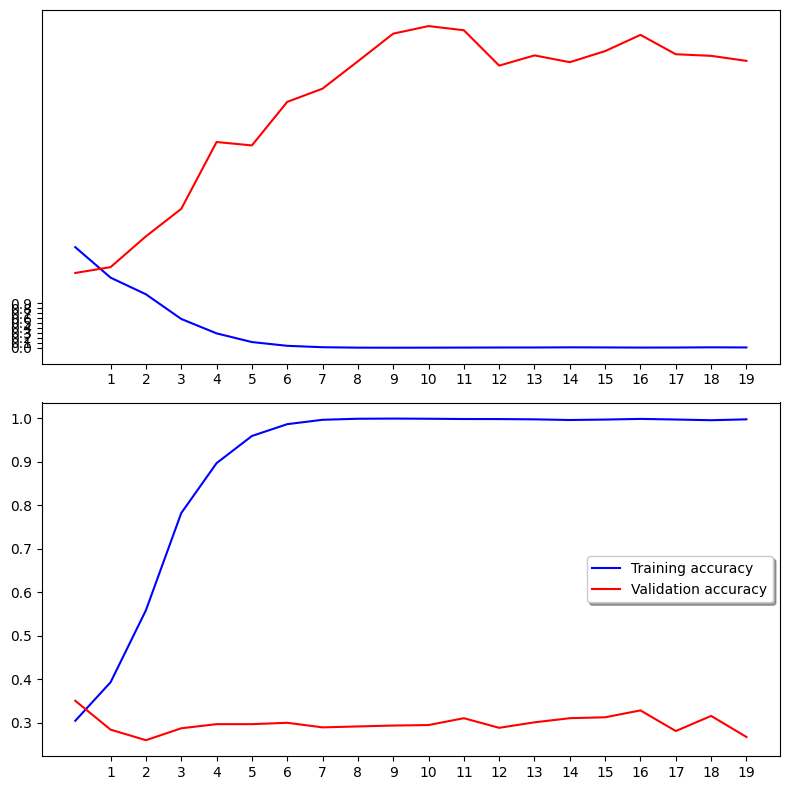

In [164]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history2.history['loss'], color='b', label="Training loss")
ax1.plot(history2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 20, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()